# Example Fitting Notebook - updated July 19th 2022

author - Elliot Wadge

check for newer notebooks at - https://github.com/Elliot-Wadge/MagnetizationFitting

you can install the functions in this notebook to your version of python with `pip install git+https://github.com/Elliot-Wadge/MagnetizationFitting`

then import them with `from magnetizationfitting import *`

In [10]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from scipy.integrate import solve_ivp
import scipy
from datetime import date

In [2]:
pio.templates.default = "simple_white"

# Defining Functions

In [3]:
#derivatives of the first order system of equations for the continuous case
def negative_derivatives(x,y,H,A,Ms):
    dw = (H*Ms)/(2*A*10)*np.sin(y[0])
    dtheta = y[1]
    if dw == 0 and dtheta == 0:
        #known unstable solution give nudge
        dw += 1e-7
    return -np.array([dtheta, dw])

#residuals of the boundary condition in the reverse direction 0 is the edge of the device and 
#last element is the interface
def negative_boundary_conditions(theta,w, J1, J2, A):
    return np.sum(-2*A*10*w[-1] - J1*np.sin(2*theta[-1]) - J2*np.sin(4*theta[-1]))

#shooting method vectorized for convenience
@np.vectorize
def shoot(theta0, H, J1, J2, A, Ms, half_thickness):
    tspan = (0,half_thickness)
    x = np.linspace(0,half_thickness,1000)
    sol = solve_ivp(negative_derivatives, tspan, [theta0,0], args = [H,A,Ms], t_eval = x, rtol = 1e-8)
    theta = sol.y[0]
    w = sol.y[1]
    return negative_boundary_conditions(theta, w, J1, J2, A)

In [4]:
def fit_function(fields, J1, J2, A, Ms, half_thickness, zero_bound=1e-4, sorted=True):
    '''fitting function for the shooting solution, FIELDS MUST BE IN ASCENDING
    ORDER IF sorted=True this allows for massive speed up in run time'''
    # initialize array for storing return array
    mag = np.zeros(len(fields))
    x = np.linspace(0, half_thickness, int(half_thickness*10))
    upper_bound = np.pi/2
    for index, H in enumerate(fields):

        # upon nearing saturation the solution becomes zero the solver requires
        # a point on either side of axis so this causes
        # error the except handles and sets theta0 to zero because we are at saturation
        try:
            theta0 = scipy.optimize.brentq(shoot,
                                           zero_bound,
                                           upper_bound,
                                           xtol=1e-4,
                                           args=(H, J1, J2, A, Ms, half_thickness))
        except ValueError:
            theta0 = 0

        # range to solve the equation over
        tspan = (0, max(x))
        sol = solve_ivp(negative_derivatives, tspan, [theta0, 0],
                        args=[H, A, Ms], t_eval=x, rtol=1e-5)
        thetas_opt = sol.y[0]
        value = 1/(len(x))*sum(np.cos(thetas_opt))
        mag[index] = value
        if sorted:
            upper_bound = theta0
        if 1 - value < 1e-4:
            # if we reached saturation no reason to continue computing
            mag[index:] = 1
            break
    return mag



# Fitting Tail

a = -4.21e-05
b = 3.24e-04
avg_moment = 3.24e-04


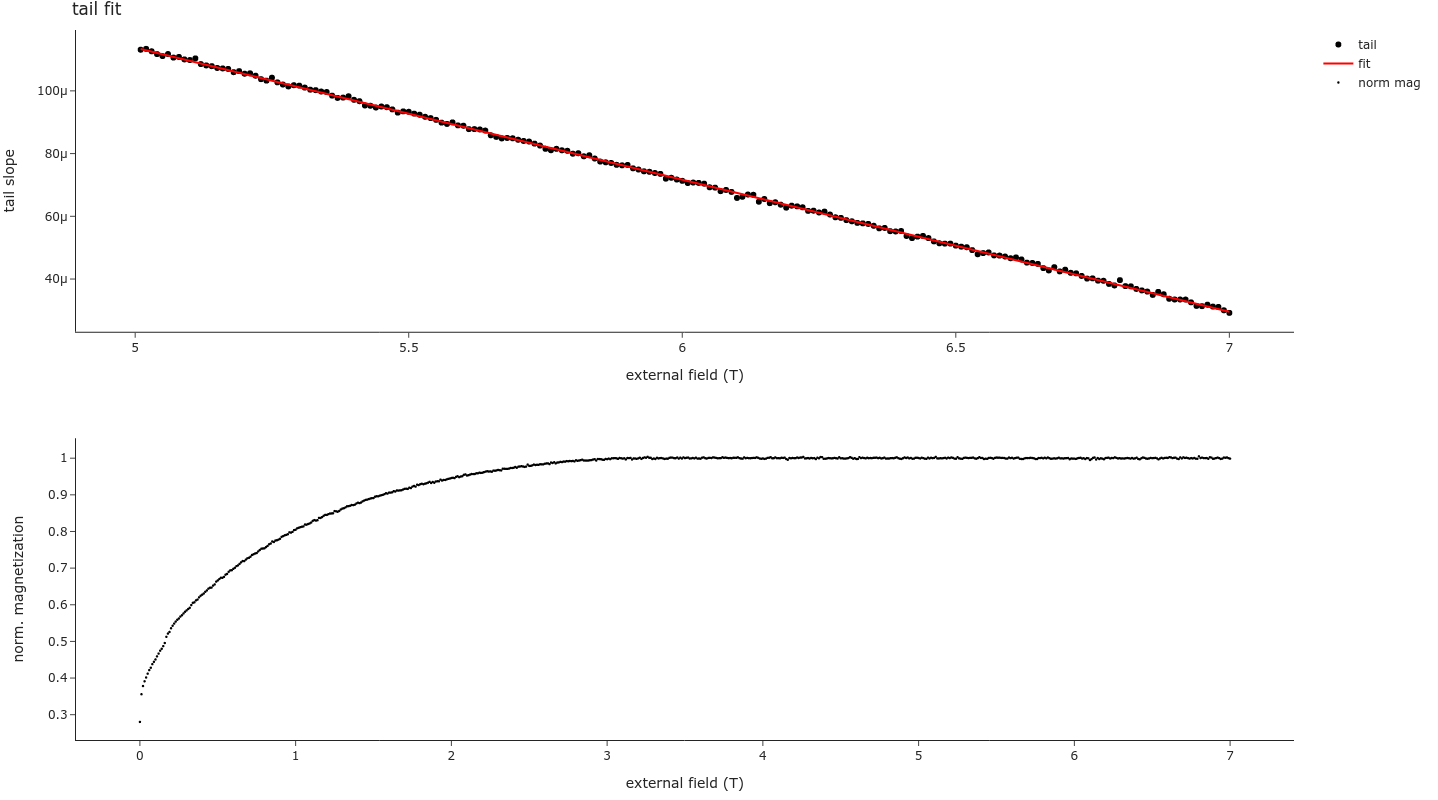

In [5]:
filename = 'J1-7-inplane-295K-N-avg.txt'

#load data and transpose it into columns
field, momentRaw = np.genfromtxt(filename, delimiter = '\t', unpack = True)



#extract the last N amount of points
length_of_last_points = 200
tail_x = field[-length_of_last_points:] 
tail_y = momentRaw[-length_of_last_points:]
#fit the tail
a, b = np.polyfit(tail_x, tail_y, 1)



#get some information
moment = momentRaw - field*a
avg_moment = np.mean(moment[-length_of_last_points:])
norm_moment = moment/avg_moment
print(f"a = {a:.2e}\nb = {b:.2e}\navg_moment = {avg_moment:.2e}")

#plot
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=tail_x,
                         y=tail_y,
                         mode="markers",
                         name="tail",
                         marker=dict(color='black')),
              row=1,
              col=1)

fig.add_trace(go.Scatter(x=tail_x,
                         y=tail_x*a+b,
                         name="fit",
                         mode="lines",
                         line=dict(color="red")),
              row=1,
              col=1)

fig.add_trace(go.Scatter(x=field,
                         y=norm_moment,
                         mode="markers",
                         marker=dict(color='black', size=2.5),
                         name="norm mag"),
              row=2,
              col=1)

fig.update_layout(title="tail fit", margin=dict(t=30,r=30,l=30,b=30), width=800, height=800)
fig.update_yaxes(title_text="norm. magnetization",  row=2, col=1)
fig.update_yaxes(title_text="tail slope",  row=1, col=1)
fig.update_xaxes(title_text="external field (T)",  row=1, col=1)
fig.update_xaxes(title_text="external field (T)",  row=2, col=1)
fig.show()



# Constants

In [6]:
half_thickness = 4  #in units of nm this is nicer for the solver
S = 0.2946635385  #in cm^2
Ms = avg_moment/(2*half_thickness)/S*10**4  #again changing the units to be nice to the solver
ratio_MrMs = momentRaw[0]  #not used in solver
print(f'Ms = {Ms*1000}')  #actual Ms
print(f"half thickness = {half_thickness} nm")
print(f"S = {S} cm^2")

Ms = 1375.8349110381441
half thickness = 4 nm
S = 0.2946635385 cm^2


# Curve Fit

In [7]:
#initial guesses
J1 = 2
J2 = 2
A = 3

#we need to not fit Ms and half_thickness and since the 'args' in curve_fit seems to not work lambda is the easiest way
f = lambda H,J1,J2,A: fit_function(H,J1,J2,A,Ms,half_thickness)
#warning: %time hides error message, if pOpt is not defined delete %time and rerun or just remove altogether
%time pOpt, pCov = scipy.optimize.curve_fit(f, field, norm_moment, p0 = [J1,J2,A], bounds = ((0,0,0),(5,5,3)))
y_fit = f(field,*pOpt)
print(f"J1 = {pOpt[0]}\nJ2 = {pOpt[1]}\nA = {pOpt[2]}")

Wall time: 53.5 s
J1 = 2.690650567374045
J2 = 1.6888815228930862
A = 2.9999999999999996


# Results and Residuals

red chisq = 7.279 +/- 0.054 

J1 = 2.6907 +/- 0.0037
J2 = 1.6889 +/- 0.0038
A = 3.0000 +/- 0.0361 

measured saturation field = 3.03 T
fit saturation field = 2.95 T

theta_data = 142.8
theta_model = 180.0
theta = 161.4

Ms = 1.38e+00
Mr = 1.25e-04
Mr/Ms = 9.09e-05



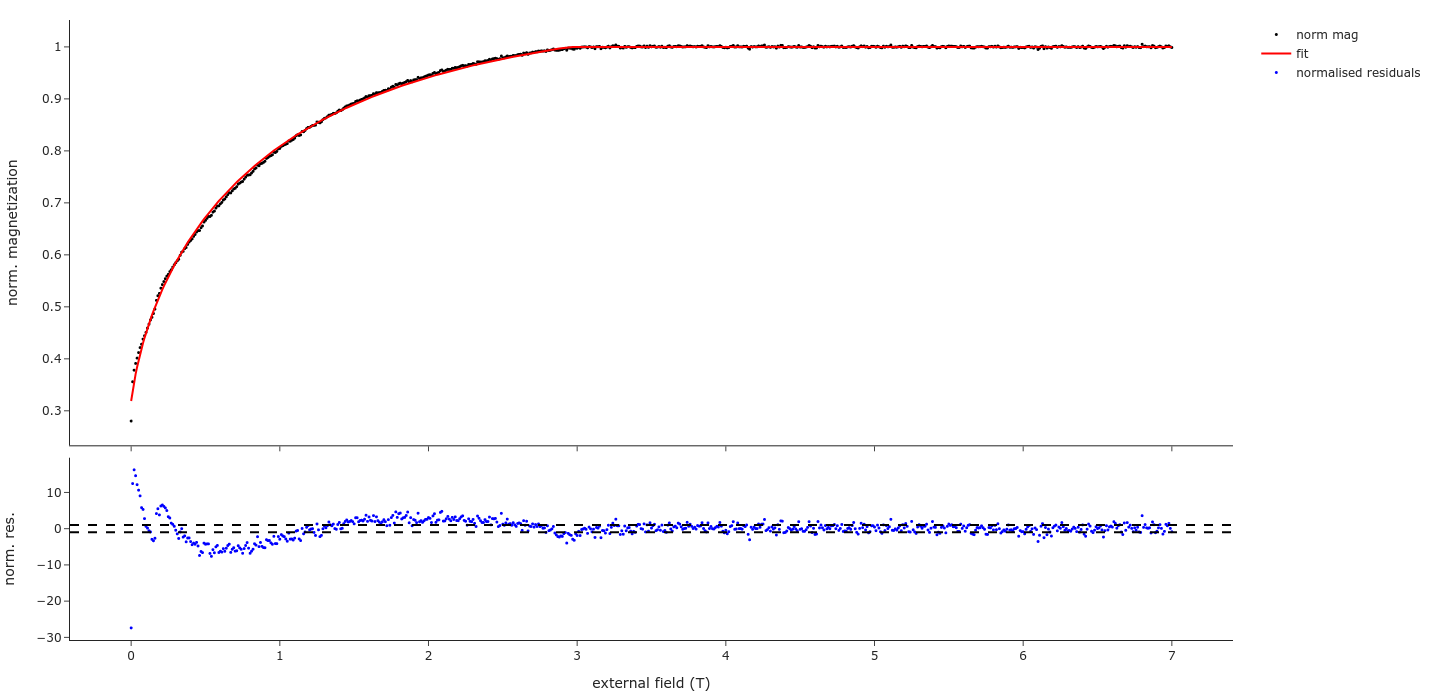

In [8]:
sigma = np.std(norm_moment[-length_of_last_points:])
#calculate chisq from the standard deviation of the tail
res = (norm_moment - y_fit)
norm_res = res/sigma

#get chisq and other significant constants
chisq_red = np.sum(norm_res**2)/(len(field))

J1, J2, A = pOpt
J1_err, J2_err, A_err = np.sqrt(np.diag(pCov))
Hsat_calc = field[np.where(y_fit==1)[0][0]]
Hsat_meas = field[np.where(np.isclose(norm_moment, 1, rtol=0.001))[0][0]]
if J1/(2*J2) < 1:
    #handle case where J1/2J2 > 1
    theta_data = 180 - np.arccos(J1/(2*J2))*180/np.pi
else:
    theta_data = 180
theta_model = 2*np.arccos(ratio_MrMs)*180/np.pi
theta = np.mean([theta_model, theta_data])


print(f"red chisq = {chisq_red:.3f} +/- {np.sqrt(2/(len(field)-len(pOpt))):.3f} \n")
print(f"J1 = {J1:.4f} +/- {J1_err:.4f}\nJ2 = {J2:.4f} +/- {J2_err:.4f}\nA = {A:.4f} +/- {A_err:.4f} \n")

print(f"measured saturation field = {Hsat_meas:.2f} T")
print(f"fit saturation field = {Hsat_calc:.2f} T\n")

print(f"theta_data = {theta_data:.1f}\ntheta_model = {theta_model:.1f}\ntheta = {theta:.1f}\n")

print(f"Ms = {Ms:.2e}\nMr = {ratio_MrMs*Ms:.2e}\nMr/Ms = {ratio_MrMs:.2e}\n")





# make plots
fig = make_subplots(rows=2, cols=1, row_heights=[0.7,0.3], shared_xaxes=True, vertical_spacing=0.02)
fig.add_trace(go.Scatter(x=field,
                         y=norm_moment,
                         mode="markers",
                         marker=dict(color="black", size=3),
                         name="norm mag"),
              row=1,
              col=1)
fig.add_trace(go.Scatter(x=field,
                         y=y_fit,
                         mode="lines",
                         line=dict(color="red"),
                         name="fit"),
              row=1,
              col=1)

fig.add_trace(go.Scatter(x=field, 
                         y=norm_res,
                         mode="markers",
                         marker=dict(color='blue', size=3),
                         name="normalised residuals"), row=2, col=1)
fig.add_hline(y=1, line=dict(color="black", dash="dash", width=2), opacity=1, row=2, col=1)
fig.add_hline(y=-1, line=dict(color="black", dash="dash", width=2), opacity=1, row=2, col=1)



fig.update_yaxes(title_text="norm. magnetization",  row=1, col=1)
fig.update_yaxes(title_text="norm. res.",  row=2, col=1)
fig.update_xaxes(title_text="external field (T)",  row=2, col=1)
fig.update_layout(margin=dict(t=20, b=20, r=20, l=20), width=900, height=700)
fig.show()


# Saving

In [12]:
header = f'''ran on: {date.today()}
method = continuous (https://github.com/Elliot-Wadge/MagnetizationFitting)
J1 = {J1:.4f} +/- {J1_err:.4f}
J2 = {J2:.4f} +/- {J2_err:.4f}
A = {A:.4f} +/- {A_err:.4f}
measured saturation field = {Hsat_meas:.2f} T
fit saturation field = {Hsat_calc:.2f} T
Ms = {Ms:.2e}
Mr = {ratio_MrMs*Ms:.2e}
Mr/Ms = {ratio_MrMs:.2e}
theta_data = {theta_data:.1f}
theta_model = {theta_model:.1f}
theta = {theta:.1f}
red chisq = {chisq_red:.3f} +/- {np.sqrt(2/(len(field)-len(pOpt))):.3f}"

Field (T),Mag (Data) (kA/m),Mag (Model) (kA/m),Residuals(kA/m)'''
print(header)

ran on: 2022-07-18
method = continuous (https://github.com/Elliot-Wadge/MagnetizationFitting)
J1 = 2.6907 +/- 0.0037
J2 = 1.6889 +/- 0.0038
A = 3.0000 +/- 0.0361
measured saturation field = 3.03 T
fit saturation field = 2.95 T
Ms = 1.38e+00
Mr = 1.25e-04
Mr/Ms = 9.09e-05
theta_data = 142.8
theta_model = 180.0
theta = 161.4
red chisq = 7.279 +/- 0.054"

Field (T),Mag (Data) (kA/m),Mag (Model) (kA/m),Residuals(kA/m)


In [13]:
outname = filename.split('.')[0] + '-out.csv'
print(f"saved to {outname}")
save = np.vstack((field, norm_moment*Ms, np.array(y_fit)*Ms, norm_moment*Ms - np.array(y_fit)*Ms))
np.savetxt(outname, save.T, delimiter=',')

saved to J1-7-inplane-295K-N-avg-out.csv
